# Case Indicium - Ciência de Dados.

 Neste projeto, o objetivo é desenvolver um modelo preditivo de precificação para aluguéis temporários em Nova York, utilizando dados de um concorrente do setor. Além disso, será realizada uma análise exploratória dos dados (EDA) para identificar padrões e relações entre as variáveis, formulando hipóteses de negócio relevantes.

Ao longo deste notebook, vou responder as seguintes perguntas:
* Qual a melhor localização para investir em um imóvel para alugar?
* Como o número mínimo de noites e a disponibilidade ao longo do ano impactam o preço?
* Existem padrões nos nomes dos locais para os imóveis mais caros?
* Como construir um modelo preditivo para estimar o preço de aluguel e quais métricas serão utilizadas para avaliar sua performance?

Por fim, apresentarei uma sugestão de preço para um apartamento específico, utilizando as análises e o modelo desenvolvido.

# Abordagem metodológica 
Para solucionar esse case irei seguir o modelo CRISP-DM, pois fornece um modelo estruturado e flexível, aplicável a uma ampla variedade de problemas, seguirei com as seguintes etapas:
- Compreensão do problema a ser solucionado.
- Entendimento dos Dados.
- Preparação dos Dados.
- Modelagem.
- Avaliação.

   <div style="text-align: center;">
    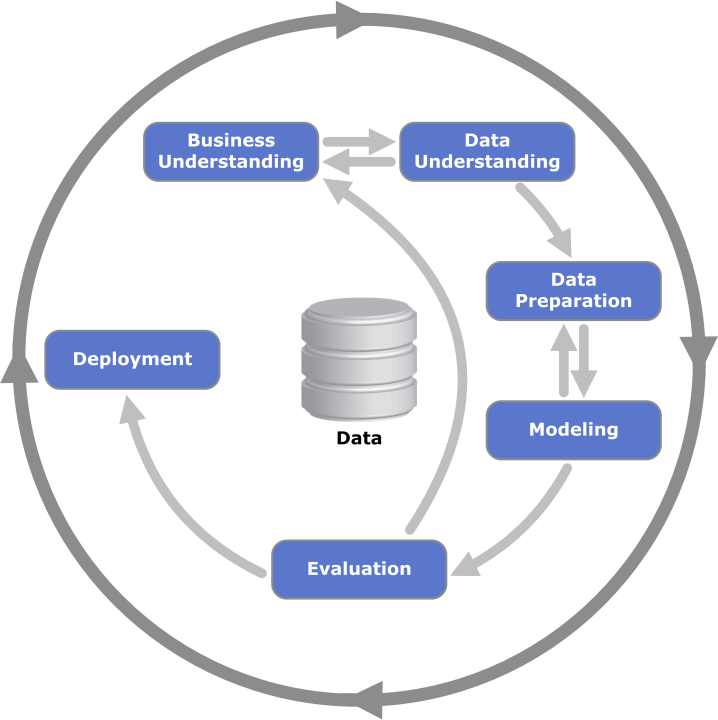
</div>

## Importando Bibliotecas

In [336]:
pip install geopy

Note: you may need to restart the kernel to use updated packages.


In [437]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import time
from geopy.distance import geodesic


import warnings
from sklearn.preprocessing import MinMaxScaler, LabelEncoder, StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV
from sklearn import metrics
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
import pickle

warnings.filterwarnings("ignore")

In [338]:
df = pd.read_csv('/home/adrielle/Anaconda/teste_indicium_precificacao.csv')

In [339]:
df.head(3)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194


# Análise exploratória dos Dados
Nas seguintes células estou realizando a compreensão dos dados, detectando anomalias, identificando relacionamentos, verificando a forma de distribuição das variáveis e identificando as caracteristicas principais. 

In [340]:
df.shape

(48894, 16)

<b>Verificando o tamanho do DataFrame

In [341]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48894 entries, 0 to 48893
Data columns (total 16 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   id                             48894 non-null  int64  
 1   nome                           48878 non-null  object 
 2   host_id                        48894 non-null  int64  
 3   host_name                      48873 non-null  object 
 4   bairro_group                   48894 non-null  object 
 5   bairro                         48894 non-null  object 
 6   latitude                       48894 non-null  float64
 7   longitude                      48894 non-null  float64
 8   room_type                      48894 non-null  object 
 9   price                          48894 non-null  int64  
 10  minimo_noites                  48894 non-null  int64  
 11  numero_de_reviews              48894 non-null  int64  
 12  ultima_review                  38842 non-null 

<b> Verificando as informações presentes no "df". Aparentemente apenas a coluna "ultima_review" que deveria ser tipo data, mas está em tipo object.

In [342]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
count,4.889400e+04,4.889400e+04,48894.000000,48894.000000,48894.000000,48894.000000,48894.000000,38842.000000,48894.000000,48894.000000
mean,1.901753e+07,6.762139e+07,40.728951,-73.952169,152.720763,7.030085,23.274758,1.373251,7.144005,112.776169
std,1.098288e+07,7.861118e+07,0.054529,0.046157,240.156625,20.510741,44.550991,1.680453,32.952855,131.618692
min,2.595000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.472371e+06,7.822737e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967743e+07,3.079553e+07,40.723075,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915225e+07,1.074344e+08,40.763117,-73.936273,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


Nessa célula estou buscando entender a distribuição dos dados usando um resumo estatístico, com as métricas count (numero de valores não nulos), mean (media), std( desvio padrão), min (valor mínimo), 25% (1º quartil), 50% (mediana), 75% (3º quartil), max (valor maximo).

<b> Análises possiveis de identificar: </b>
- A coluna *reviews_por_mes* pode conter valores faltando, visto que ela tem 38.842 valores enquanto as outras possuem 48.894.
- A média da coluna *price* é 152.72. O preço médio é maior do que a mediana que é 106, isso pode indicar que outliers podem está puxando a média para cima. O mínimo é 0 o que pode ser acomodações gratuitas ou apenas um erros.O máximo é 10.000 o devo ter que análisar, pois pode ser outlier.
- A coluna *minimo_noites* a média é 7 noites, mas a mediana é 3. O máximo são 1250 noites, o que é um valor bem alto, portanto pode ser um indicador de outlier.
- Coluna *numero_de_reviews* tem a média 23, mas a mediana 5 (pode indicar um outlier). Algumas acomodações tem bastante avaliações.
- Coluna *disponibilidade_365* tem mediana 45, 75% dos imóveis estão disponiveis por até 227 dias e algumas estão disponíveis o ano inteiro (max 365).

In [343]:
df.duplicated().sum()

0

**Verificando a existência de dados duplicados. Não há.**

In [344]:
valores_faltantes = df.isnull().sum()
print(valores_faltantes)

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
dtype: int64


**Verificando a existência de valores nulos presentes no DataFrame** <br>
Há presença de valores nulos nas colunas: *nome*, *host_name*, *ultima_review* e *reviews_por_mes*.

In [345]:
df.bairro_group.unique()

array(['Manhattan', 'Brooklyn', 'Queens', 'Staten Island', 'Bronx'],
      dtype=object)

**Lista de nomes de todos as zonas de NY presentes no DataFrame**

In [346]:
df.columns

Index(['id', 'nome', 'host_id', 'host_name', 'bairro_group', 'bairro',
       'latitude', 'longitude', 'room_type', 'price', 'minimo_noites',
       'numero_de_reviews', 'ultima_review', 'reviews_por_mes',
       'calculado_host_listings_count', 'disponibilidade_365'],
      dtype='object')

**Lista de identificação das colunas presentes no DataFrame**

In [347]:
df.groupby('bairro')['price'].mean().sort_values(ascending=False)

bairro
Fort Wadsworth    800.000000
Woodrow           700.000000
Tribeca           490.638418
Sea Gate          487.857143
Riverdale         442.090909
                     ...    
New Dorp           57.000000
Soundview          53.466667
Tremont            51.545455
Hunts Point        50.500000
Bull's Head        47.333333
Name: price, Length: 221, dtype: float64

**Verificando o valor médio de preços dos bairros mais caros de NY**</br>
Os 5 bairros mais caros são: Fort Wadsworth, Woodrow, Tribeca, Sea Gate e Riverdale.

Text(0.5, 1.0, 'Distribuição de preços por bairros')

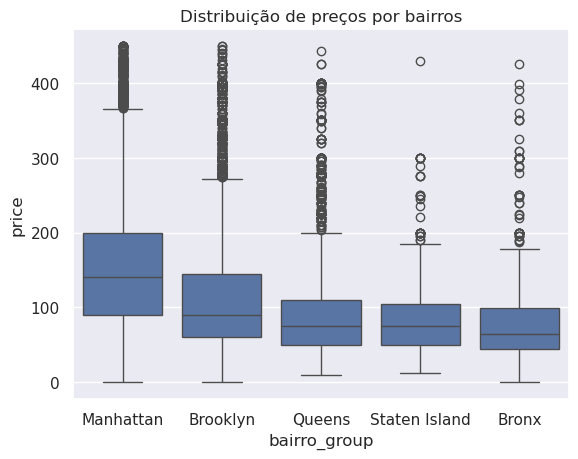

In [348]:
sns.boxplot(x='bairro_group', y='price', data=df[df.price <450])\
.set_title('Distribuição de preços por bairros')

Uso do gráfico bloxplot para exibir a distribuição dos preços em diferentes bairros, mostrando a mediana quartis e outliers. 


<b> Com a visualização do gráfico podemos identificar que Manhattan é o bairro com os preços mais altos e Bronx com os preços mais baixos.<br>
Note também que Queens e Stanten Island possuem distribuições parecidas, porem Stanten Island tende a ter menos outliers comparado a outras zonas.</b>

In [349]:
df.corr(numeric_only=True)

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
id,1.000000,0.588282,-0.003178,0.090896,0.010618,-0.013235,-0.319782,0.291810,0.133274,0.085541
host_id,0.588282,1.000000,0.020199,0.127049,0.015309,-0.017370,-0.140113,0.296406,0.154951,0.203535
latitude,-0.003178,0.020199,1.000000,0.084777,0.033939,0.024861,-0.015399,-0.010168,0.019517,-0.010926
longitude,0.090896,0.127049,0.084777,1.000000,-0.150020,-0.062750,0.059092,0.145941,-0.114713,0.082751
price,0.010618,0.015309,0.033939,-0.150020,1.000000,0.042799,-0.047954,-0.030608,0.057472,0.081833
minimo_noites,-0.013235,-0.017370,0.024861,-0.062750,0.042799,1.000000,-0.080118,-0.121708,0.127960,0.144320
numero_de_reviews,-0.319782,-0.140113,-0.015399,0.059092,-0.047954,-0.080118,1.000000,0.549865,-0.072376,0.172047
reviews_por_mes,0.291810,0.296406,-0.010168,0.145941,-0.030608,-0.121708,0.549865,1.000000,-0.009421,0.185835
calculado_host_listings_count,0.133274,0.154951,0.019517,-0.114713,0.057472,0.127960,-0.072376,-0.009421,1.000000,0.225711
disponibilidade_365,0.085541,0.203535,-0.010926,0.082751,0.081833,0.144320,0.172047,0.185835,0.225711,1.000000


**Matriz de correlação entre as variáveis numéricas.**

<Axes: >

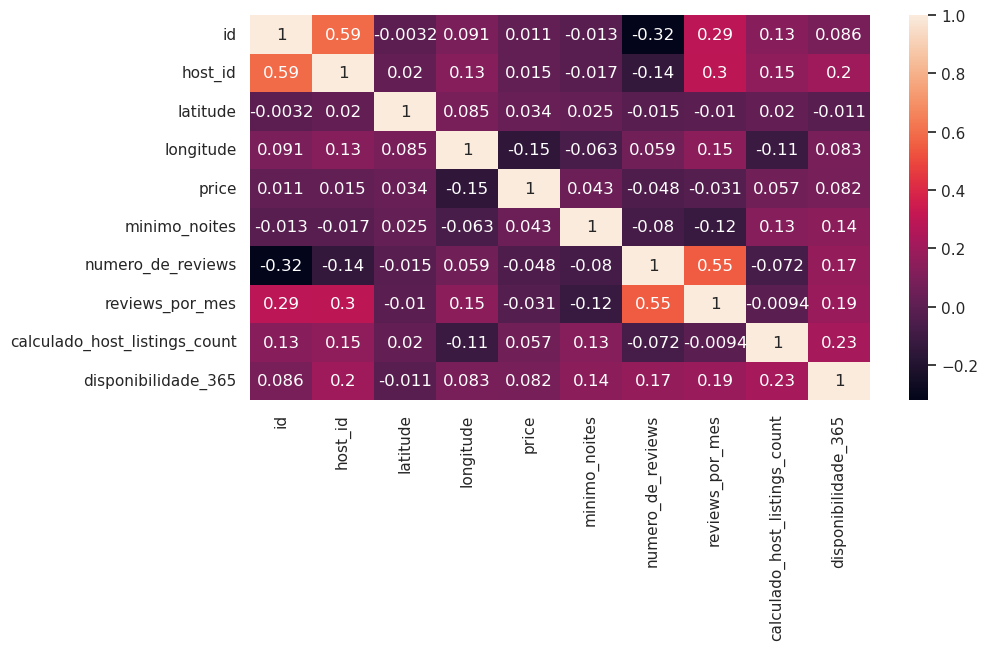

In [350]:
plt.figure(figsize = (10,5))
sns.heatmap(df.corr(numeric_only=True), annot = True)


**O uso do gráfico heatmap nos ajuda a identificar quais varáveis estão correlacionadas, sendo importante para entender as relações entre os dados.<br>
    A análise é feita da seguinte forma: <br>
    - As células com cores mais intensas indicam correlações mais fortes (positivas ou negativas), enquanto as cores mais claras indicam correlações fracas ou nulas.<br>
    -Os valores numéricos dentro das células representam o coeficiente de correlação entre as variáveis correspondentes**.


<b> Algumas análises possiveis desse gráfico: <br>
- *price e minimo_noites(0.043)*: Há uma correlação baixa, então podemos entender que o preço não está fortemente relacionado ao número mínimo de noites exigidas.
- *numero_de_reviews e reviews_por_mes(0.55)*: Correlação media positiva, podemos entender que propriedades com mais reviews tendem ter mais reviews por mês.
- *price e longitude(-0.15)*: Essa correlação negativa pode indicar que propriedades em determinadas longitudes tendem a ter preços um pouco mais baixos.

In [351]:
df.room_type.value_counts()

room_type
Entire home/apt    25409
Private room       22325
Shared room         1160
Name: count, dtype: int64

**Filtrando os dados por tipo de acomodações.** </br>
É possivel visualizar que a maioria dos anúncios na base são do tipo Entire home/apt.

In [352]:
df.groupby('room_type')[['disponibilidade_365']].mean()

,disponibilidade_365
room_type,
Entire home/apt,111.920304
Private room,111.192564
Shared room,162.000862


**Nessa célula estou tentando entender a dinâmica de ocupação dos diferentes tipos de acomodação realizando o calculo de média da disponilibilidade anual para cada tipo de quarto.**</br>
É possivel dizer que os tipos Shared room, média, ficam mais tempo disponiveis ao longo do ano comparado com os outros dois tipos que possuem diposbildiade semelhante entre si.

In [353]:
df.groupby('bairro_group')[['numero_de_reviews']].mean()

,numero_de_reviews
bairro_group,
Bronx,26.004583
Brooklyn,24.203601
Manhattan,20.985596
Queens,27.700318
Staten Island,30.941019


**Aqui estou fazendo o calculo médio do número de avaliações para cada Zona.<br>
Visualizei que o Bronx é a zona com maior numero de avaliações.**

In [354]:
df.groupby('bairro_group')[['price']].mean()

,price
bairro_group,
Bronx,87.496792
Brooklyn,124.381983
Manhattan,196.875814
Queens,99.517649
Staten Island,114.812332


**Aqui realizo o calculo médio dos preços para cada zona de bairros.<br>
É possivel visualizar que o Bronx é a zona com menor preço.**

In [355]:
df[df.bairro_group =='Manhattan'].groupby('bairro')[['disponibilidade_365']].mean()

,disponibilidade_365
bairro,
Battery Park City,100.328571
Chelsea,113.995508
Chinatown,90.796196
Civic Center,68.269231
East Harlem,98.973142
East Village,74.623853
Financial District,191.536290
Flatiron District,123.050000
Gramercy,94.526627


**Analisando qual é a média de dias disponíveis por ano para cada bairro dentro de Manhattan(o bairro mais caro).** 

In [356]:
bairros_review= df.groupby('bairro')[['reviews_por_mes']].mean().sort_values(by= 'reviews_por_mes', ascending=False).head(20).reset_index()

In [357]:
bairros_review

,bairro,reviews_por_mes
0,New Dorp Beach,5.500000
1,East Elmhurst,4.822982
2,Springfield Gardens,4.455250
3,Silver Lake,4.340000
4,Rosebank,3.812857
5,Huguenot,3.760000
6,Whitestone,3.320000
7,Jamaica Hills,3.315714
8,Queens Village,3.220800
9,South Ozone Park,3.178684


**Estou agrupando os dados por bairro e calculando a média da coluna *reviews_por_mes*, depois ordenando o resultado de forma decrescente por essa coluna**. </b>
**É possivel perceber que o bairro que tem mais numeros de avaliações por mês é o bairro New Dorp Beach. Há uma diferença significativa no número médio de revisões entre os bairros de maiores avaliações e os de menores.**

In [358]:
bairros_disponibilidade = (
    df.groupby(['bairro', 'bairro_group'])[['disponibilidade_365','numero_de_reviews', 'price']]
    .mean()
    .sort_values(by=['disponibilidade_365','numero_de_reviews', 'price'], ascending=[True, False, True])
    .head(20)
    .reset_index()
)

**Nessa célula eu faço o agrupamento dos dados de *bairro* e *bairro_group* e para cada grupo calculo a média das colunas *disponibilidade_365*, *numero_de_reviews* e *price*, faço a ordenação da exibição da coluna *disponibilidade_365* em ordem crescente, *numero_de_reviews* em ordem decrescente e *price* em ordem crescente.**

In [359]:
bairros_disponibilidade

,bairro,bairro_group,disponibilidade_365,numero_de_reviews,price
0,"Bay Terrace, Staten Island",Staten Island,0.000000,1.500000,102.500000
1,New Dorp,Staten Island,0.000000,0.000000,57.000000
2,Woodrow,Staten Island,0.000000,0.000000,700.000000
3,Downtown Brooklyn,Brooklyn,39.481928,14.313253,150.349398
4,Morningside Heights,Manhattan,43.054913,13.291908,114.783237
5,Navy Yard,Brooklyn,48.928571,17.928571,151.642857
6,Rossville,Staten Island,59.000000,21.000000,75.000000
7,Cobble Hill,Brooklyn,63.212121,29.171717,211.929293
8,Stuyvesant Town,Manhattan,65.108108,8.162162,169.108108
9,New Springville,Staten Island,65.250000,29.375000,76.000000


**Analisando os bairro_group, em média, Manhatttan cobra o maior valor, o que faz sentido pois é o centro da cidade onde tem mais pontos turisticos. Em contrapartida tem, em media a menor quatidade de rewiews, o que pode indicar falta de engajamento por uma série de motivos como hospedagem curtas, com poucas noites.**

## Qual a melhor localização para investir em um imóvel para alugar?

Para responder essa pergunta levei em consideração os seguintes criérios:
- Local que possui disponibilidade, mas que não fique vago durante o ano todo.
- Possuir quantidade significativa de reviews, mesmo não tendo os dados da qualidade dessas avaliações, considerei que ter uma boa quantidade de avaliações pode indicar engajamento com a estadia.
- Um bom preço.<br>
**Atendendo a esses critérios e analisando os dados, considero como melhor local o Morningside Heights, pois fica em Manhattan, possui em média uma disponibildiade de 43 dias e tem um valor médio abaixo da média da região**.

## Como o número mínimo de noites e a disponibilidade ao longo do ano impactam o preço?
A estratégia aqui é verificar a variação do preço e das variáveis disponibilidade e mínimo de noites.

In [360]:
df['ultima_review'] = pd.to_datetime(df.ultima_review)

In [361]:
df['mes']= df.ultima_review.dt.month

In [362]:
df['year']= df.ultima_review.dt.year

**Criando colunas ano e mês a partir da última review para obter temporalidade**

In [363]:
correlacao = df.groupby(['mes'])[['minimo_noites', 'price', 'disponibilidade_365']].mean().reset_index().corr()
correlacao

,mes,minimo_noites,price,disponibilidade_365
mes,1.000000,-0.174132,0.044011,-0.241675
minimo_noites,-0.174132,1.000000,-0.060725,-0.674694
price,0.044011,-0.060725,1.000000,-0.241565
disponibilidade_365,-0.241675,-0.674694,-0.241565,1.000000


**Através da correlação dos meses em geral, quando o mês aumenta, ou seja, os meses do fim do ano, há uma tendência de diminuir a disponibilidade. Outro insgiht é que a há correlação negativa entre preço e disponibilidade, o que faz sentido com a lógica do mercado, diminuindo a oferta o preços tendem a subir por aumentar a demanda.**

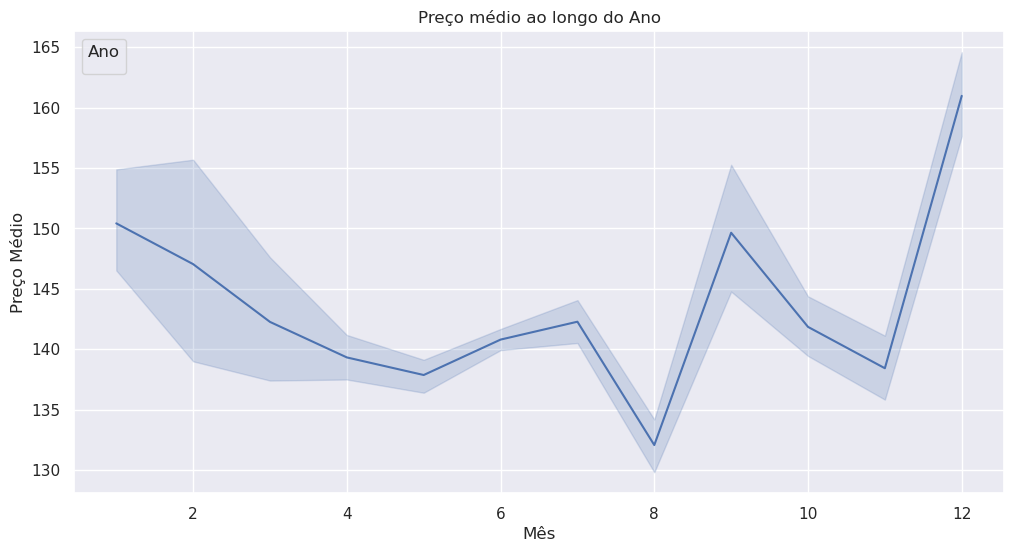

In [364]:
df_sorted = df.sort_values(by=[ 'mes', 'minimo_noites'])
df_sorted['price_smooth'] = df_sorted['price'].rolling(window=10, min_periods=1).mean()

plt.figure(figsize=(12, 6))
sns.lineplot(data=df_sorted, x='mes', y='price_smooth', palette='tab10')
plt.title('Preço médio ao longo do Ano')
plt.xlabel('Mês')
plt.ylabel('Preço Médio')
plt.legend(title='Ano')
plt.show()

**É possível observar que o pico dos valores é no fim fim/ínicio de ano o que corresponde há férias, feriados de fim de ano e inverno no hemisfério norte. Depois, em média os preços vão baixando e tem o menor preço médio em agosto**.

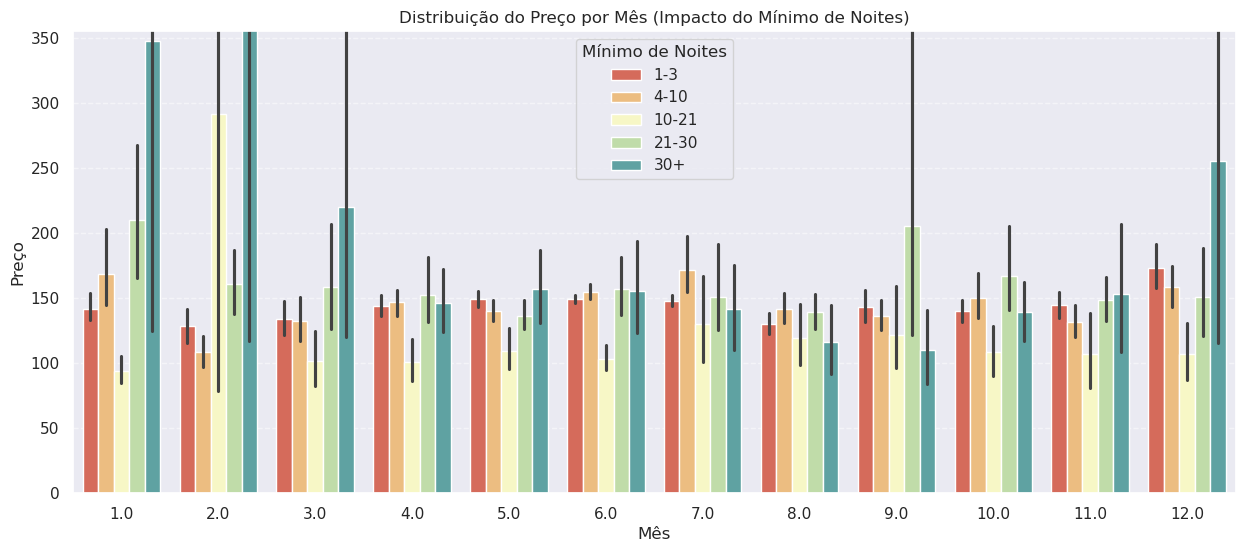

In [365]:
plt.figure(figsize=(15, 6))
sns.barplot(
    data=df, 
    x='mes', 
    y='price', 
    hue=pd.cut(df['minimo_noites'], bins=[1, 3, 10, 21, 30, float('inf')], 
               labels=['1-3', '4-10', '10-21', '21-30', '30+']), 
    palette='Spectral'
)

plt.title('Distribuição do Preço por Mês (Impacto do Mínimo de Noites)')
plt.xlabel('Mês')
plt.ylabel('Preço')
plt.legend(title='Mínimo de Noites')
plt.ylim(0, df['price'].quantile(0.95))
plt.grid(axis='y', linestyle='--', alpha=0.5)
plt.show()

**Após a criação do gráfico de barras para visualizar a distribuição de preços por mês, destacando o impacto do mínimo de noites, podemos observar que o preço médio do mínimo de noites como 1-3 noites variam pouco sendo sustabcial somente no período do fim do ano, como comentado na análise anterior. É notável uma tendêndia de aumentos dos valores das acomodações com  uma mínimo de noites muito grandes, provalvelmente casas que alugal o mês inteiro ou para temporada**.

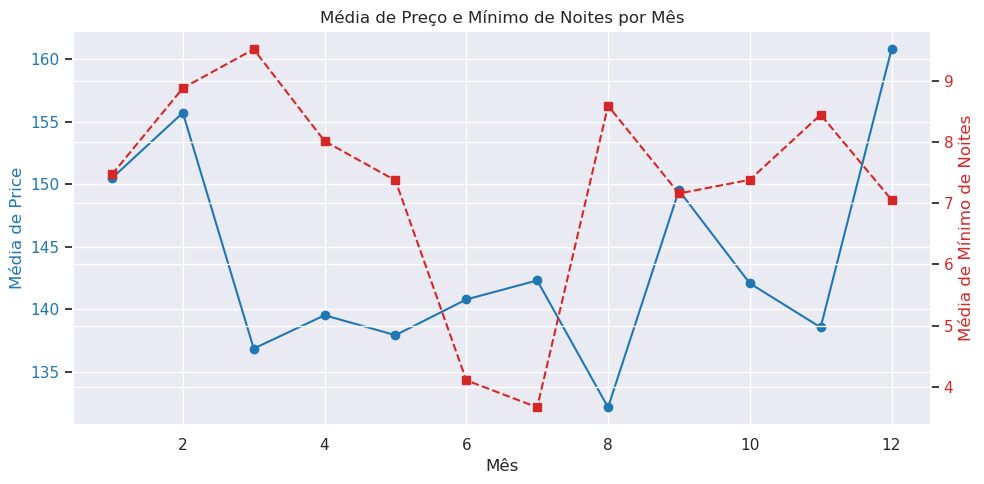

In [366]:
df_grouped = df.groupby('mes').agg({'price': 'mean', 'minimo_noites': 'mean'}).reset_index()
fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel("Mês")
ax1.set_ylabel("Média de Price", color="tab:blue")
ax1.plot(df_grouped['mes'], df_grouped['price'], marker='o', linestyle='-',\
         color="tab:blue", label="Média de Price")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Média de Mínimo de Noites", color="tab:red")
ax2.plot(df_grouped['mes'], df_grouped['minimo_noites'], marker='s', linestyle='--',\
         color="tab:red", label="Média de Mínimo de Noites")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.xticks(rotation=45)
plt.title("Média de Preço e Mínimo de Noites por Mês")
fig.tight_layout()
plt.grid(True)
plt.show()

**O gráfico acima permite comparar como o preço médio e o mínimo de noites variam ao longo dos meses. Assim como já foi destacado no gráfico anterior, há uma flutuação na média de preço e no mínimo de noites, que pode está associado a fatores de sazionalidade, como feriado e ferias, Também há uma correlação entre o aumento do preço e o aumento do mínimo de noites durantes certos meses, como é o caso dos primeiros e últimos meses do ano**.

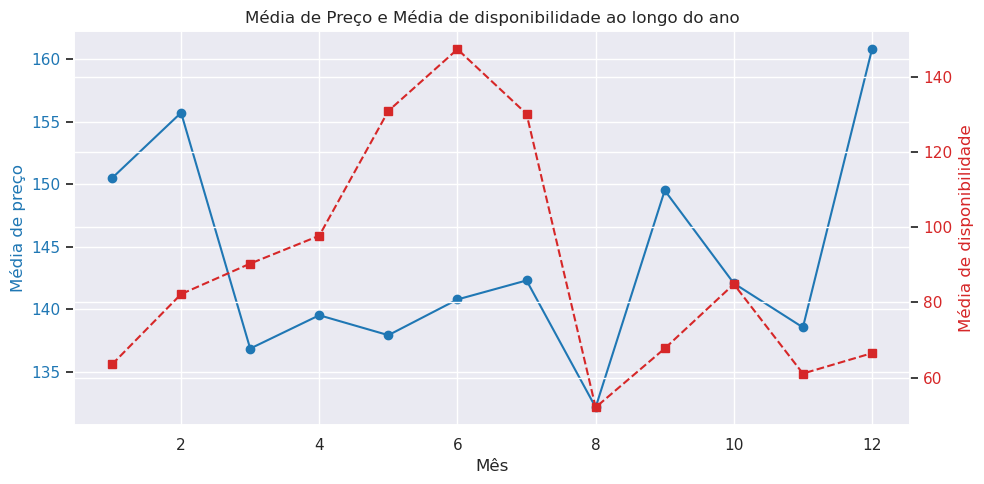

In [367]:
df_grouped = df.groupby('mes').agg({'price': 'mean', 'disponibilidade_365': 'mean'}).reset_index()

fig, ax1 = plt.subplots(figsize=(10, 5))
ax1.set_xlabel("Mês")
ax1.set_ylabel("Média de preço", color="tab:blue")
ax1.plot(df_grouped['mes'], df_grouped['price'], marker='o', linestyle='-',\
         color="tab:blue", label="Média de Price")
ax1.tick_params(axis='y', labelcolor="tab:blue")
ax2 = ax1.twinx()
ax2.set_ylabel("Média de disponibilidade", color="tab:red")
ax2.plot(df_grouped['mes'], df_grouped['disponibilidade_365'], marker='s', linestyle='--',\
         color="tab:red", label="Média de disponibilidade")
ax2.tick_params(axis='y', labelcolor="tab:red")

plt.xticks(rotation=45)
plt.title("Média de Preço e Média de disponibilidade ao longo do ano")
fig.tight_layout()
plt.grid(True)
plt.show()

**No gráfico acima analiso se há relação entre a média de preço e a disponibilidade ao longo do ano. É possivél perceber uma correlação inversa entre a média de preço e a média de disponibilidade, ou seja, quando os preços são mais altos, a disponibilidade tende a ser menor.**

### Como o número mínimo de noites e a disponibilidade ao longo do ano impactam o preço?

**Feito as ánalises podemos dizer que é notável uma tendêndia de aumentos dos valores das acomodações com uma mínimo de noites muito grandes e que quando os preços estão mais altos a disponibilidade tende a ser menor.** 

## Existem padrões nos nomes dos locais para os imóveis mais caros?

In [368]:
df.sort_values(by='price',ascending= False).head(25)[['nome','price']]

,nome,price
9150,Furnished room in Astoria apartment,10000
29237,1-BR Lincoln Center,10000
17691,Luxury 1 bedroom apt. -stunning Manhattan views,10000
12341,"Quiet, Clean, Lit @ LES & Chinatown",9999
40432,2br - The Heart of NYC: Manhattans Lower East ...,9999
6529,Spanish Harlem Apt,9999
30267,Beautiful/Spacious 1 bed luxury flat-TriBeCa/Soho,8500
4376,Film Location,8000
29661,East 72nd Townhouse by (Hidden by Airbnb),7703
45665,Gem of east Flatbush,7500


**Visualizando os 25 anúncios mais caros do DataFrame, mostrando o nome e o preço de cada um**.

In [369]:
mais_caros = df.sort_values(by='price',ascending= False).head(100)[['nome','price']]

In [370]:
words = " ".join(mais_caros ['nome'].dropna()).lower().split() 
word_counts = Counter(words)
df_word_counts = pd.DataFrame(word_counts.items(),\
                              columns=['Palavra', 'Frequência']).sort_values(by='Frequência', ascending=False)
df_word_counts.head(20)

,Palavra,Frequência
2,in,18
8,luxury,14
42,by,14
10,bedroom,12
4,apartment,10
103,2,9
23,-,8
85,loft,8
41,townhouse,8
121,for,7


**Acima foi feito a analise das palavras mais frequentes nos nomes dos 100 anúncios mais caros do "df". É possível notar que algumas palavras aparecem nos nomes do anuncios mais caros, como exemplo: "luxury", "townhouse", "hidden". Portanto podemos dizer que há um padrão nos nomes do imóveis mais caros.´**

# Preparação dos Dados.

In [371]:
df.isnull().sum()

id                                   0
nome                                16
host_id                              0
host_name                           21
bairro_group                         0
bairro                               0
latitude                             0
longitude                            0
room_type                            0
price                                0
minimo_noites                        0
numero_de_reviews                    0
ultima_review                    10052
reviews_por_mes                  10052
calculado_host_listings_count        0
disponibilidade_365                  0
mes                              10052
year                             10052
dtype: int64

In [372]:
df = df.dropna(subset=['host_name', 'nome', 'ultima_review', 'reviews_por_mes'])


In [373]:
df.isnull().sum()


id                               0
nome                             0
host_id                          0
host_name                        0
bairro_group                     0
bairro                           0
latitude                         0
longitude                        0
room_type                        0
price                            0
minimo_noites                    0
numero_de_reviews                0
ultima_review                    0
reviews_por_mes                  0
calculado_host_listings_count    0
disponibilidade_365              0
mes                              0
year                             0
dtype: int64

**Retirando os valores faltantes para garantir que todas as linhas do dataframe tenham valores preenchidos nas colunas essenciais para a análise. O objetivo com isso é evitar problemas quando for realizado cálculos ou gráficos que dependem dessas colunas**.

In [374]:
def get_estacao(data):
    mes = data.month
    if mes in [12, 1, 2]:
        return 'Inverno'
    elif mes in [3, 4, 5]:
        return 'Primavera'
    elif mes in [6, 7, 8]:
        return 'Verão'
    else:
        return 'Outono'

In [375]:
df['estacao'] = df['ultima_review'].apply(get_estacao)
df['reviews_por_dia'] = df['reviews_por_mes'] / 30

**Criando a variavel estação do ano, pois pode haver alguma relação com tempo, época do ano e férias a questão de alocação das acomodações**.

In [376]:

def calcular_distancia(lat, lon):
    times_square = (40.7580, -73.9855) 
    return geodesic((lat, lon), times_square).kilometers


In [377]:
df['distance_to_times_square'] = df.apply(lambda row: calcular_distancia(row['latitude'],\
                                                                         row['longitude']), axis=1)

In [378]:
df

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mes,year,estacao,reviews_por_dia,distance_to_times_square
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,45,2019-05-21,0.38,2,355,5.0,2019.0,Primavera,0.012667,0.507861
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,270,2019-07-05,4.64,1,194,7.0,2019.0,Verão,0.154667,8.378165
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,9,2018-11-19,0.10,1,0,11.0,2018.0,Outono,0.003333,5.702325
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,74,2019-06-22,0.59,1,129,6.0,2019.0,Verão,0.019667,1.449890
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,...,49,2017-10-05,0.40,1,0,10.0,2017.0,Outono,0.013333,8.282728
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48781,36425863,Lovely Privet Bedroom with Privet Restroom,83554966,Rusaa,Manhattan,Upper East Side,40.78099,-73.95366,Private room,129,...,1,2019-07-07,1.00,1,147,7.0,2019.0,Verão,0.033333,3.707321
48789,36427429,No.2 with queen size bed,257683179,H Ai,Queens,Flushing,40.75104,-73.81459,Private room,45,...,1,2019-07-07,1.00,6,339,7.0,2019.0,Verão,0.033333,14.453440
48798,36438336,Seas The Moment,211644523,Ben,Staten Island,Great Kills,40.54179,-74.14275,Private room,235,...,1,2019-07-07,1.00,1,87,7.0,2019.0,Verão,0.033333,27.447149
48804,36442252,1B-1B apartment near by Metro,273841667,Blaine,Bronx,Mott Haven,40.80787,-73.92400,Entire home/apt,100,...,2,2019-07-07,2.00,1,40,7.0,2019.0,Verão,0.066667,7.590723


**Criando uma variável que mede a distância do imovel até a Times Square, um dos principais pontos turísticos de Nova York, usando a formula de haversine que mede a distância entre coordenadas.**

In [379]:
df['anuncios_por_bairro'] = df['bairro'].map(df['bairro'].value_counts())
df['anuncios_por_bairro_group'] = df['bairro_group'].map(df['bairro_group'].value_counts())

In [380]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mes,year,estacao,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,0.38,2,355,5.0,2019.0,Primavera,0.012667,0.507861,986,16621
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,4.64,1,194,7.0,2019.0,Verão,0.154667,8.378165,480,16438
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0.10,1,0,11.0,2018.0,Outono,0.003333,5.702325,943,16621
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,0.59,1,129,6.0,2019.0,Verão,0.019667,1.449890,311,16621
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,...,0.40,1,0,10.0,2017.0,Outono,0.013333,8.282728,3141,16438


**Criação da densidade de acomodaçãoes por bairro e bairro_group, pois locais com maior densidade pode ter um impacto no valor da alocação**.

In [381]:
df['valor_media_bairro'] = df['bairro'].map(df.groupby('bairro')['price'].mean())
df['valor_medio_bairro_group'] = df['bairro_group'].map(df.groupby('bairro_group')['price'].mean())

In [382]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,disponibilidade_365,mes,year,estacao,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,355,5.0,2019.0,Primavera,0.012667,0.507861,986,16621,267.583164,180.071596
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,194,7.0,2019.0,Verão,0.154667,8.378165,480,16438,176.158333,121.461613
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,0,11.0,2018.0,Outono,0.003333,5.702325,943,16621,132.746554,180.071596
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,129,6.0,2019.0,Verão,0.019667,1.449890,311,16621,218.083601,180.071596
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,...,0,10.0,2017.0,Outono,0.013333,8.282728,3141,16438,105.958930,121.461613


**Criação de média de preço do bairro e região, para ajudar a estimar o valor baseado também no bairro, pois essa coluna (bairro) será removida na modelagem**.

In [383]:
def classify_host_experience(count):
    if count == 1:
        return 'Casual'
    elif count == 2:
        return 'Intermediário'
    elif count <= 10:
        return 'Experiente'
    else:
        return 'Super Host'

df['host_level'] = df.calculado_host_listings_count.map(classify_host_experience)

In [384]:
df.head()

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,mes,year,estacao,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group,host_level
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,...,5.0,2019.0,Primavera,0.012667,0.507861,986,16621,267.583164,180.071596,Intermediário
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,...,7.0,2019.0,Verão,0.154667,8.378165,480,16438,176.158333,121.461613,Casual
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,...,11.0,2018.0,Outono,0.003333,5.702325,943,16621,132.746554,180.071596,Casual
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,...,6.0,2019.0,Verão,0.019667,1.449890,311,16621,218.083601,180.071596,Casual
5,5121,BlissArtsSpace!,7356,Garon,Brooklyn,Bedford-Stuyvesant,40.68688,-73.95596,Private room,60,...,10.0,2017.0,Outono,0.013333,8.282728,3141,16438,105.958930,121.461613,Casual


**Criando uma variavel do experiencia do host, feateure que existe na platafarom da Airbnb, host com mais experiência oferencem um maior engajamento e por consequência imapacto no preço**.

### Verificando os outliers

In [385]:
df[df.price == 0]

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,mes,year,estacao,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group,host_level
23160,18750597,"Huge Brooklyn Brownstone Living, Close to it all.",8993084,Kimberly,Brooklyn,Bedford-Stuyvesant,40.69023,-73.95428,Private room,0,...,1.0,2018.0,Inverno,0.001667,7.974594,3141,16438,105.958930,121.461613,Experiente
25432,20333471,★Hostel Style Room | Ideal Traveling Buddies★,131697576,Anisha,Bronx,East Morrisania,40.83296,-73.88668,Private room,0,...,6.0,2019.0,Verão,0.085333,11.783366,10,875,85.000000,79.558857,Experiente
25633,20523843,"MARTIAL LOFT 3: REDEMPTION (upstairs, 2nd room)",15787004,Martial Loft,Brooklyn,Bushwick,40.69467,-73.92433,Private room,0,...,5.0,2019.0,Primavera,0.023667,8.727251,1942,16438,85.129248,121.461613,Experiente
25752,20608117,"Sunny, Quiet Room in Greenpoint",1641537,Lauren,Brooklyn,Greenpoint,40.72462,-73.94072,Private room,0,...,10.0,2017.0,Outono,0.017667,5.295847,866,16438,144.435335,121.461613,Intermediário
25777,20624541,Modern apartment in the heart of Williamsburg,10132166,Aymeric,Brooklyn,Williamsburg,40.70838,-73.94645,Entire home/apt,0,...,1.0,2018.0,Inverno,0.005000,6.422157,3163,16438,139.812520,121.461613,Casual
25793,20639628,Spacious comfortable master bedroom with nice ...,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68173,-73.91342,Private room,0,...,6.0,2019.0,Verão,0.142667,10.431884,3141,16438,105.958930,121.461613,Experiente
25794,20639792,Contemporary bedroom in brownstone with nice view,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68279,-73.91170,Private room,0,...,6.0,2019.0,Verão,0.145667,10.422796,3141,16438,105.958930,121.461613,Experiente
25795,20639914,Cozy yet spacious private brownstone bedroom,86327101,Adeyemi,Brooklyn,Bedford-Stuyvesant,40.68258,-73.91284,Private room,0,...,6.0,2019.0,Verão,0.145000,10.384267,3141,16438,105.958930,121.461613,Experiente
26840,21291569,Coliving in Brooklyn! Modern design / Shared room,101970559,Sergii,Brooklyn,Bushwick,40.69211,-73.90670,Shared room,0,...,6.0,2019.0,Verão,0.003667,9.892338,1942,16438,85.129248,121.461613,Experiente
26865,21304320,Best Coliving space ever! Shared room.,101970559,Sergii,Brooklyn,Bushwick,40.69166,-73.90928,Shared room,0,...,5.0,2019.0,Primavera,0.008667,9.784567,1942,16438,85.129248,121.461613,Experiente


**Por alguma razão existem anúncios com os preços zerados, o que não faz muito sentido, devido a isso esse dados serão removidos para a modelagem**

In [386]:
df= df[df.price != 0]

In [387]:
num_cols = df.select_dtypes(exclude=["object", "datetime64"]).columns.tolist()

In [433]:
def outlier_thresholds(dataframe, col_name, q1=0.05, q3=0.95):
    """
    Calcula os limites inferior e superior para detecção de outliers em uma coluna específica de um DataFrame.

    A função utiliza o método do intervalo interquartil (IQR) para definir os limites de outliers.
    O usuário pode especificar os percentis usados para calcular o primeiro e o terceiro quartis.
    """
    quartile1 = dataframe[col_name].quantile(q1)
    quartile3 = dataframe[col_name].quantile(q3)
    interquantile_range = quartile3 - quartile1
    up_limit = quartile3 + 1.5 * interquantile_range
    low_limit = quartile1 - 1.5 * interquantile_range
    return low_limit, up_limit

In [432]:
def check_outlier(dataframe, col_name):
    """
    Verifica se uma coluna do Dataframe contém outliers com base nos limites calculados pelo método IQR.

    A função utiliza a função outlier_thresholds para calcular os limites inferior e superior
    e verifica se há valores que excedem esses limites.
    """
    low_limit, up_limit = outlier_thresholds(dataframe, col_name)
    if dataframe[(dataframe[col_name] > up_limit) | (dataframe[col_name] < low_limit)].any(axis=None):
        return True
    else:
        return False

In [390]:
def replace_with_thresholds(dataframe, variable):
    """
    Substitui os outliers de uma coluna de um Dataframe pelo limites inferior e superior calculados pelo método IQR.

    A função utiliza outlier_thresholds para determinar os limites e substitui os valores que estão abaixo do limite inferior pelo próprio limite inferior e os valores acima do limite superior pelo próprio limite superior.
    """
    
    low_limit, up_limit = outlier_thresholds(dataframe, variable)
    dataframe.loc[(dataframe[variable] < low_limit), variable] = low_limit
    dataframe.loc[(dataframe[variable] > up_limit), variable] = up_limit

In [391]:
for col in num_cols:
    print(col, check_outlier(df, col))

id False
host_id False
latitude False
longitude True
price True
minimo_noites True
numero_de_reviews True
reviews_por_mes True
calculado_host_listings_count True
disponibilidade_365 False
mes False
year True
reviews_por_dia True
distance_to_times_square False
anuncios_por_bairro False
anuncios_por_bairro_group False
valor_media_bairro False
valor_medio_bairro_group False


In [392]:
for col in num_cols:
    if check_outlier(df, col):
        replace_with_thresholds(df, col)

In [393]:
for col in num_cols:
    print(col, check_outlier(df, col))

id False
host_id False
latitude False
longitude False
price False
minimo_noites False
numero_de_reviews False
reviews_por_mes False
calculado_host_listings_count False
disponibilidade_365 False
mes False
year False
reviews_por_dia False
distance_to_times_square False
anuncios_por_bairro False
anuncios_por_bairro_group False
valor_media_bairro False
valor_medio_bairro_group False


In [394]:
for col in num_cols:
    if check_outlier(df, col):
        df = replace_with_thresholds(df, col)

**No bloco acima estou identificando as colunas numéricas, calculando os limites de outliers usando percentis de 5% e 95%, após verifico quais colunas contêm valores extremos, substituo os outliers pelos limites definidos e após só confirmo que os outliers foram removidos corretamente. Escolhi essa estratégia para não perder as outras informações que se perderiam caso eu simplesmente removesse os outliers**.

In [396]:
df.describe()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mes,year,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group
count,3.881000e+04,3.881000e+04,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000,38810.000000
mean,1.810065e+07,6.424776e+07,40.728136,-73.951153,137.105263,5.413051,29.092888,2018-10-04 06:51:04.406081024,1.369179,2.499974,114.875187,6.174053,2018.288341,0.045639,7.258536,1227.210590,14637.569518,142.342013,142.338812
min,2.595000e+03,2.438000e+03,40.506410,-74.215119,10.000000,1.000000,1.000000,2011-03-28 00:00:00,0.010000,1.000000,0.000000,1.000000,2011.500000,0.000333,0.072383,1.000000,314.000000,38.000000,79.558857
25%,8.721029e+06,7.028672e+06,40.688640,-73.982470,69.000000,1.000000,3.000000,2018-07-09 00:00:00,0.190000,1.000000,0.000000,5.000000,2018.000000,0.006333,3.981704,311.000000,16438.000000,105.958930,121.461613
50%,1.887190e+07,2.837092e+07,40.721710,-73.954810,101.000000,2.000000,9.000000,2019-05-19 00:00:00,0.720000,1.000000,55.000000,6.000000,2019.000000,0.024000,6.670276,943.000000,16438.000000,132.746554,121.461613
75%,2.757003e+07,1.018889e+08,40.762997,-73.935030,170.000000,4.000000,33.000000,2019-06-23 00:00:00,2.020000,2.000000,229.000000,7.000000,2019.000000,0.067333,9.518602,1942.000000,16621.000000,176.158333,180.071596
max,3.645581e+07,2.738417e+08,40.913060,-73.712990,767.750000,73.500000,321.000000,2019-07-08 00:00:00,11.540000,21.000000,365.000000,12.000000,2019.000000,0.384667,35.238077,3163.000000,16621.000000,482.500000,180.071596
std,1.069477e+07,7.590399e+07,0.054992,0.046678,109.946083,9.081646,46.698183,NaN,1.633541,3.911491,129.530852,2.531297,1.180168,0.054451,4.424456,1048.547742,4573.664011,53.468745,34.067061


**Visualizando como ficou a estatistica descritiva das varíaveis. Como esperado, a média das colunas que tinham outliers diminuiu, já que os valores extremos foram ajustados para o limite superior, por exemplo**.

#### Escalonando as variáveis

In [397]:
num_cols = [col for col in num_cols if col not in ["price"]]

In [399]:
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])
df.head(10)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,...,mes,year,estacao,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group,host_level
0,-1.692256,Skylit Midtown Castle,-0.846408,Jennifer,Manhattan,Midtown,0.463415,-0.698771,Entire home/apt,225.0,...,-0.463821,0.603023,Primavera,-0.605550,-1.525784,-0.230046,0.433669,2.342355,1.107617,Intermediário
2,-1.692141,Cozy Entire Floor of Brownstone,-0.846381,LisaRoxanne,Brooklyn,Clinton Hill,-0.781880,-0.184390,Entire home/apt,89.0,...,0.326298,0.603023,Verão,2.002315,0.253058,-0.712624,0.393657,0.632458,-0.612834,Casual
3,-1.692029,Entire Apt: Spacious Studio/Loft by central park,-0.846351,Laura,Manhattan,East Harlem,1.279732,0.153460,Entire home/apt,80.0,...,1.906536,-0.244325,Outono,-0.776959,-0.351734,-0.271055,0.433669,-0.179462,1.107617,Casual
4,-1.692022,Large Cozy 1 BR Apartment In Midtown East,-0.846349,Chris,Manhattan,Murray Hill,0.355216,-0.510886,Entire home/apt,200.0,...,-0.068761,0.603023,Verão,-0.476994,-1.312867,-0.873801,0.433669,1.416576,1.107617,Casual
5,-1.692020,BlissArtsSpace!,-0.846349,Garon,Brooklyn,Bedford-Stuyvesant,-0.750239,-0.102980,Private room,60.0,...,1.511477,-1.091672,Outono,-0.593307,0.231487,1.825205,0.393657,-0.680464,-0.612834,Casual
6,-1.692015,Large Furnished Room Near B'way,-0.846327,Shunichi,Manhattan,Hell's Kitchen,0.668358,-0.723622,Private room,79.0,...,-0.068761,0.603023,Verão,1.286071,-1.467294,0.286867,0.433669,0.820650,1.107617,Casual
7,-1.692012,Cozy Clean Guest Room - Family Apt,-0.846347,MaryEllen,Manhattan,Upper West Side,1.339196,-0.344425,Private room,79.0,...,0.326298,-1.091672,Verão,-0.232124,-0.487756,0.242996,0.433669,0.827984,1.107617,Casual
8,-1.692009,Cute & Cozy Lower East Side 1 bdrm,-0.846346,Ben,Manhattan,Chinatown,-0.267250,-0.840167,Entire home/apt,150.0,...,-0.068761,0.603023,Verão,-0.023984,-0.518292,-0.864264,0.433669,0.282826,1.107617,Experiente
9,-1.692004,Beautiful 1br on Upper West Side,-0.846344,Lena,Manhattan,Upper West Side,1.364291,-0.306291,Entire home/apt,135.0,...,-0.068761,0.603023,Verão,-0.574942,-0.444272,0.242996,0.433669,0.827984,1.107617,Casual
10,-1.691990,Central Manhattan/near Broadway,-0.846340,Kate,Manhattan,Hell's Kitchen,0.593255,-0.803747,Private room,85.0,...,-0.068761,0.603023,Verão,0.080086,-1.548596,0.286867,0.433669,0.820650,1.107617,Casual


**Como os outliers foram tratados, estou utilizando o StandartScaler que é um escalonamento mais simples**

In [436]:
df.head(5)

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,225,1,45,2019-05-21,0.38,2,355
1,3647,THE VILLAGE OF HARLEM....NEW YORK !,4632,Elisabeth,Manhattan,Harlem,40.80902,-73.94190,Private room,150,3,0,NaN,NaN,1,365
2,3831,Cozy Entire Floor of Brownstone,4869,LisaRoxanne,Brooklyn,Clinton Hill,40.68514,-73.95976,Entire home/apt,89,1,270,2019-07-05,4.64,1,194
3,5022,Entire Apt: Spacious Studio/Loft by central park,7192,Laura,Manhattan,East Harlem,40.79851,-73.94399,Entire home/apt,80,10,9,2018-11-19,0.10,1,0
4,5099,Large Cozy 1 BR Apartment In Midtown East,7322,Chris,Manhattan,Murray Hill,40.74767,-73.97500,Entire home/apt,200,3,74,2019-06-22,0.59,1,129


**Verificando novamente o dataframe após o escalonamento das variáveis numéricas**

### Enconding 

In [401]:
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

In [402]:
cat_cols

['nome',
 'host_name',
 'bairro_group',
 'bairro',
 'room_type',
 'estacao',
 'host_level']

In [403]:
df = df.drop(columns=['nome', 'host_name', 'bairro'])
cat_cols = df.select_dtypes(include=["object", "category"]).columns.tolist()

In [438]:
def one_hot_encoder(dataframe, categorical_cols, drop_first=False):
    dataframe = pd.get_dummies(dataframe, columns=categorical_cols, drop_first=False)
    return dataframe

In [405]:
df = one_hot_encoder(df, cat_cols, drop_first=True)

In [406]:
df.head()

,id,host_id,latitude,longitude,price,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,...,room_type_Private room,room_type_Shared room,estacao_Inverno,estacao_Outono,estacao_Primavera,estacao_Verão,host_level_Casual,host_level_Experiente,host_level_Intermediário,host_level_Super Host
0,-1.692256,-0.846408,0.463415,-0.698771,225.0,-0.485937,0.340641,2019-05-21,-0.605550,-0.127824,...,False,False,False,False,True,False,False,False,True,False
2,-1.692141,-0.846381,-0.781880,-0.184390,89.0,-0.485937,5.158878,2019-07-05,2.002315,-0.383484,...,False,False,False,False,False,True,True,False,False,False
3,-1.692029,-0.846351,1.279732,0.153460,80.0,0.505086,-0.430277,2018-11-19,-0.776959,-0.383484,...,False,False,False,True,False,False,True,False,False,False
4,-1.692022,-0.846349,0.355216,-0.510886,200.0,-0.265710,0.961658,2019-06-22,-0.476994,-0.383484,...,False,False,False,False,False,True,True,False,False,False
5,-1.692020,-0.846349,-0.750239,-0.102980,60.0,4.359062,0.426299,2017-10-05,-0.593307,-0.383484,...,True,False,False,True,False,False,True,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48781,1.713497,0.254367,0.961134,-0.053706,129.0,-0.485937,-0.601592,2019-07-07,-0.226002,-0.383484,...,True,False,False,False,False,True,True,False,False,False
48789,1.713644,2.548455,0.416499,2.925675,45.0,-0.485937,-0.601592,2019-07-07,-0.226002,0.894818,...,True,False,False,False,False,True,False,True,False,False
48798,1.714663,1.941909,-3.388673,-4.104697,235.0,-0.485937,-0.601592,2019-07-07,-0.226002,-0.383484,...,True,False,False,False,False,True,True,False,False,False
48804,1.715030,2.761338,1.449941,0.581718,100.0,-0.485937,-0.580178,2019-07-07,0.386173,-0.383484,...,False,False,False,False,False,True,True,False,False,False


**Verificando novamente o dataframe após o a criação das variaveis dummies**

# Modelagem e avaliação

Esse é um **problema de regressão porque queremos prever um valor numérico**, o preço das acomodações. O modelo analisará vários fatores, como tipo de acomodação, localização e disponibilidade, entre outros, para calcular um preço estimado. Diferente de uma classificação, onde colocaríamos os imóveis em categorias, aqui o objetivo é prever um número exato.

In [407]:
df = df.drop(columns=['id', 'host_id', 'ultima_review'])

In [408]:
df.columns

Index(['latitude', 'longitude', 'price', 'minimo_noites', 'numero_de_reviews',
       'reviews_por_mes', 'calculado_host_listings_count',
       'disponibilidade_365', 'mes', 'year', 'reviews_por_dia',
       'distance_to_times_square', 'anuncios_por_bairro',
       'anuncios_por_bairro_group', 'valor_media_bairro',
       'valor_medio_bairro_group', 'bairro_group_Bronx',
       'bairro_group_Brooklyn', 'bairro_group_Manhattan',
       'bairro_group_Queens', 'bairro_group_Staten Island',
       'room_type_Entire home/apt', 'room_type_Private room',
       'room_type_Shared room', 'estacao_Inverno', 'estacao_Outono',
       'estacao_Primavera', 'estacao_Verão', 'host_level_Casual',
       'host_level_Experiente', 'host_level_Intermediário',
       'host_level_Super Host'],
      dtype='object')

**Removendo colunas categórias, como os ids, que não fazem sentido para a tarefa ou não ajudariam o modelo a entender a relação entre as variveis**

In [411]:
y = df["price"]

In [412]:
X = df.drop(["price"], axis=1)

In [413]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [414]:
models = [
    ('RF', RandomForestRegressor()),
    ("XGBoost", XGBRegressor(objective='reg:squarederror'))
]

rmse_scores = []
r2_scores = []
mae_scores = []
mse_scores = []
execution_times = []

for name, regressor in models:
    start_time = time.time()
    regressor.fit(X_train, y_train)
    y_pred = regressor.predict(X_test)
    
    rmse = np.mean(np.sqrt(-cross_val_score(regressor, X, y, cv=5, scoring="neg_mean_squared_error")))
    rmse_scores.append(rmse)
    r2 = metrics.r2_score(y_test, y_pred)
    r2_scores.append(r2)
    mae = metrics.mean_absolute_error(y_test, y_pred)
    mae_scores.append(mae)
    mse = metrics.mean_squared_error(y_test, y_pred)
    mse_scores.append(mse)

    execution_time = time.time() - start_time
    execution_times.append(execution_time)

    print(f"RMSE: {round(rmse, 4)} ({name})")
    print(f"R^2 Score: {round(r2, 4)} ({name})")
    print(f"MAE: {round(mae, 4)} ({name})")
    print(f"MSE: {round(mse, 4)} ({name})")
    print(f"Execution Time: {round(execution_time, 2)} seconds\n")

RMSE: 83.8655 (RF)
R^2 Score: 0.4663 (RF)
MAE: 46.3143 (RF)
MSE: 6350.5686 (RF)
Execution Time: 175.48 seconds

RMSE: 85.8759 (XGBoost)
R^2 Score: 0.464 (XGBoost)
MAE: 46.5394 (XGBoost)
MSE: 6378.0219 (XGBoost)
Execution Time: 1.28 seconds



Utilizei somente dois modelos para atividade, modelos bem conhecidos e clássicos para tarefas de ML, que são o Random Forest e o Xgboost. Obseravando as métricas utilizadas R² score, RMSE (Raiz do Erro Quadrático Médio ), MAE (Erro Absoluto Médio) e MSE (Erro Quadrático Médio) podemos resumir a performance dos modelos: 
- **O Random Forest teve um desempenho ligeiramente melhor do que o XGBoost** em todos as métricas (RMSE, MAE e MSE).
- No entanto, a diferença entre os dois modelos não é muito grande, indicando que ambos estão capturando o padrão dos dados de maneira semelhante.
- Ambos os modelos têm um MAE acima de 46, o que indica que, em média, erram por esse valor ao fazer previsões do preço em dólares.
- **Ambos os modelos apresentam um R² Score em torno de 0.46, o que indica que explicam apenas 46% da variância dos dados**. Os modelos podem estar subajustados e/ou talvez falte alguma variável relevante que ajude mais o ajuste do modelo.
- Apesar do RandomForest ter um desempenho levemente superior, **o tempo de execução do XGBoost é bem menor**, ou seja, é bem mais eficiente ao entregar uma perfomance muito parece em menos tempo, o que pode ser um fator decisivo dependendo da aplicação.


In [415]:
final_model = XGBRegressor(objective='reg:squarederror')
final_model.fit(X_train, y_train)
y_final_pred = final_model.predict(X_test)
final_y_pred = y_final_pred
final_y_test = y_test

results = pd.DataFrame({'Predicted Price': final_y_pred, 'True Price': final_y_test})
results['Difference'] = results['True Price'] - results['Predicted Price']

In [416]:
print(results)

       Predicted Price  True Price  Difference
39333       162.115555       172.0    9.884445
16054        69.043602        65.0   -4.043602
2020         95.504990        98.0    2.495010
31813        62.307556        59.0   -3.307556
19877       104.495628       110.0    5.504372
...                ...         ...         ...
36292       180.459015       210.0   29.540985
34081        73.077477        75.0    1.922523
21572       176.140503       250.0   73.859497
12966        98.481598       100.0    1.518402
35382       243.207611       280.0   36.792389

[7762 rows x 3 columns]


**Registrando o modelo final escolhido para fazer a previsão**

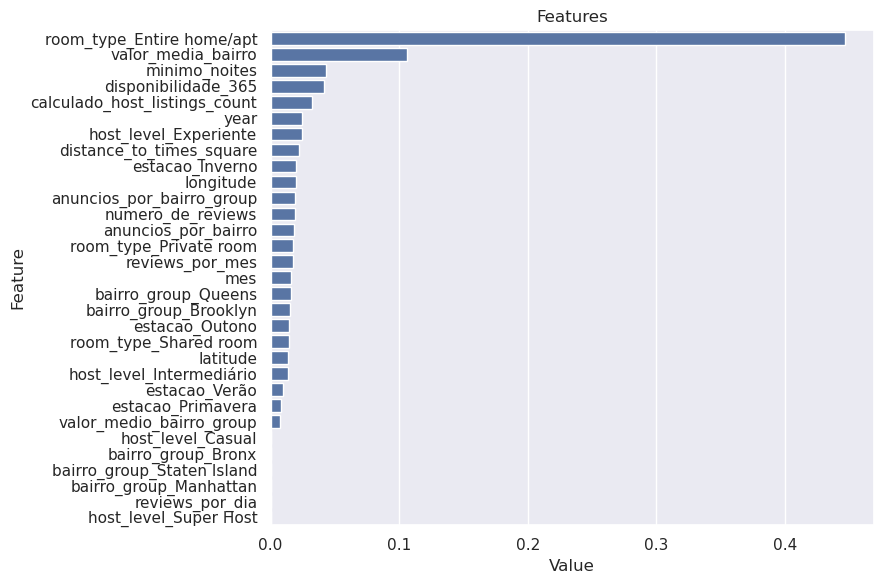

In [417]:
def plot_importance(model, features, num=50, save=False):
    feature_imp = pd.DataFrame({'Value': model.feature_importances_, 'Feature': features.columns})
    plt.figure(figsize=(9, 6))
    sns.set(font_scale=1)
    sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value",
                                                                     ascending=False)[0:num])
    plt.title('Features')
    plt.tight_layout()
    plt.show(block=True)
    if save:
        plt.savefig('importances.png')

plot_importance(final_model, X)

Esse gráfico mostra a importância das variáveis utilizadas no modelo. Entre os principais insights que podemos ter é:

- Podemos observar que a variável mais relevante foi room_type do tipo "Entire home/apt", indicando que o tipo de acomodação tem um grande impacto nas previsões.
- A segunda variável mais importante foi valor_medio_bairro, que representa a média de preços naquele bairro, sugerindo que a localização e os valores praticados na região influenciaram significativamente o modelo. Outras variáveis importantes pode-se citar mínimo de noites, disponibilidade_365 e a contagem de anúncios por anfitrião, mostrando que fatores como tempo mínimo de estadia e disponibilidade do imóvel também afetam as previsões.
- Já algumas variaveis tiveram pouca ou nenhuma relevância, como reviews por dia e host_level Super Host, indicando que essas características não tiveram impacto significativo no modelo. Essas variáveis poderiam ser removidas para simplificar a modelagem sem comprometer a performance.
- Outro ponto interessante a se notar é que a estação do ano aparece com alguma influência, sugerindo que a sazonalidade pode afetar os preços ou a demanda.

### Previsão

**Criando o input para ser previsto pelo modelo**

In [418]:
input_data = {
    'id': [2595],
    'nome': ['Skylit Midtown Castle'],
    'host_id': [2845],
    'host_name': ['Jennifer'],
    'bairro_group': ['Manhattan'],
    'bairro': ['Midtown'],
    'latitude': [40.75362],
    'longitude': [-73.98377],
    'room_type': ['Entire home/apt'],
    'minimo_noites': [1],
    'numero_de_reviews': [45],
    'ultima_review': ['2019-05-21'],
    'reviews_por_mes': [0.38],
    'calculado_host_listings_count': [2],
    'disponibilidade_365': [355]
}
df_input = pd.DataFrame(input_data)

In [419]:
df_input

,id,nome,host_id,host_name,bairro_group,bairro,latitude,longitude,room_type,minimo_noites,numero_de_reviews,ultima_review,reviews_por_mes,calculado_host_listings_count,disponibilidade_365
0,2595,Skylit Midtown Castle,2845,Jennifer,Manhattan,Midtown,40.75362,-73.98377,Entire home/apt,1,45,2019-05-21,0.38,2,355


**Preparando os dados para a previsão**

In [420]:
df_input['ultima_review'] = pd.to_datetime(df_input['ultima_review'])
df_input['mes']= df_input.ultima_review.dt.month
df_input['year']= df_input.ultima_review.dt.year

df_input['estacao'] = df_input['ultima_review'].apply(get_estacao)
df_input['reviews_por_dia'] = df_input['reviews_por_mes'] / 30
df_input['distance_to_times_square'] = df_input.apply(lambda row: calcular_distancia(row['latitude'], row['longitude']), axis=1)
df_input['anuncios_por_bairro'] = df_input['bairro'].map(df_input['bairro'].value_counts())
df_input['anuncios_por_bairro_group'] = df_input['bairro_group'].map(df_input['bairro_group'].value_counts())
df_input['valor_media_bairro'] = 267.583164
df_input['valor_medio_bairro_group'] = 180.071596
df_input['host_level'] = df_input.calculado_host_listings_count.map(classify_host_experience)

In [421]:
num_cols = df_input.select_dtypes(include=['int64', 'float64', 'int32']).columns.tolist()

In [422]:
variaveis_derivadas = ["price", "total_ano"]
num_cols = [col for col in num_cols if col not in variaveis_derivadas]

In [423]:
df_input[num_cols] = scaler.transform(df_input[num_cols])

In [425]:
categorical_cols = [ 'bairro_group', 'room_type','estacao','host_level']
df_input = one_hot_encoder(df_input, cat_cols)

In [426]:
df_input = df_input.drop(columns=['id', 'host_id', 'ultima_review','bairro','host_name','nome'])

In [427]:
df_input

,latitude,longitude,minimo_noites,numero_de_reviews,reviews_por_mes,calculado_host_listings_count,disponibilidade_365,mes,year,reviews_por_dia,distance_to_times_square,anuncios_por_bairro,anuncios_por_bairro_group,valor_media_bairro,valor_medio_bairro_group,bairro_group_Manhattan,room_type_Entire home/apt,estacao_Primavera,host_level_Intermediário
0,0.463415,-0.698771,-0.485937,0.340641,-0.60555,-0.127824,1.853828,-0.463821,0.603023,-0.60555,-1.525784,-1.169452,-3.200226,2.342355,1.107617,True,True,True,True


**Verificando o input antes da previsão**

**Prevendo**

In [428]:
missing_cols = set(X_train.columns) - set(df_input.columns)
for col in missing_cols:
    df_input[col] = 0 
df_input = df_input[X_train.columns]

y_pred = final_model.predict(df_input)

In [429]:
y_pred[0]

260.53815

**Conferindo se o valor faz sentido para o bairro Midtown**

In [430]:
df = pd.read_csv('/home/adrielle/Anaconda/teste_indicium_precificacao.csv')
df[df.bairro =='Midtown'][['price']].describe()

,price
count,1545.000000
mean,282.719094
std,255.327718
min,30.000000
25%,145.000000
50%,210.000000
75%,340.000000
max,5100.000000


**Verificando que o valor está poucos dólares da média e entre o 3° quartil e a mediana, podendo ser um bom palpite essa previsão**

**Salvando o modelo**

In [431]:
with open('final_model.pkl', 'wb') as file:
    pickle.dump(final_model, file)